# Setting relative pathing and importing packages

In [1]:
# Cell 2: setup imports and repo discovery
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pastas as ps
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path


warnings.filterwarnings('ignore')

# find repo root
repo_root = Path.cwd()
for candidate in [repo_root] + list(repo_root.parents):
    if (candidate / 'pyproject.toml').exists() or (candidate / '.git').exists():
        repo_root = candidate
        break
print('Repo root:', repo_root)

wiertsema_dir = repo_root / 'output_data' / 'only_csv_wiertsema'
fugro_dir = repo_root / 'output_data' / 'only_csv_fugro'    
singles_dir = repo_root / 'output_data' / 'only_csv_singles'
stressor_dir = repo_root / 'input_stressors'
out_fig = repo_root / 'output_data' / 'figures'
out_fig.mkdir(parents=True, exist_ok=True)

Repo root: d:\Users\jvanruitenbeek\data_validation


# Importing datasets 

In [2]:
name_model = "MB09_PB2"

# --- Load and clean the head data ---------------------------------------------
df_head = pd.read_csv(
    Path(singles_dir) / (name_model + ".csv"),
    index_col=0,
    parse_dates=True,
    encoding="utf-8-sig"
)

# Take first numeric column and rename to 'head'
head = df_head.select_dtypes("number").iloc[:, 0].rename("head")

# Crop to first and last valid (non-NaN) data points
df_head = head.loc[head.first_valid_index(): head.last_valid_index()]


df_prec = pd.read_csv(Path(stressor_dir) / "prec_station_249_2020.csv",
                   index_col=0, parse_dates=True)["Precipitation"]

df_evap = pd.read_csv(Path(stressor_dir) / "evap_station_249_2020.csv",
                   index_col=0, parse_dates=True)["ET"]

df_waterstand = pd.read_csv(Path(stressor_dir) / "Buitenwaterstand_Drieban_Clean.csv",
                   index_col=0, parse_dates=True)["waterstand"]

In [3]:
# Ensure indexes are sorted datetime indexes
for s in (df_head, df_prec, df_evap, df_waterstand):
    s.sort_index(inplace=True)

# Daily resamples
df_head_daily = df_head.resample("D").last()

# Use min_count=1 so empty days stay NaN instead of 0 and setting all lower values to 0
df_prec_daily = df_prec.resample("D").sum(min_count=1)
df_prec_daily = df_prec_daily.clip(lower=0)
df_evap_daily = df_evap.resample("D").sum(min_count=1)

# Daily resample waterstand
df_waterstand_daily = df_waterstand.resample("D").mean()

# Resample df_waterstand_daily to target lvl 
TARGET_LVL = -0.2  # m NAP
start_timeseries = pd.Timestamp("2020-01-01")
df_waterstand_daily_rel = df_waterstand_daily - TARGET_LVL
df_waterstand_daily_rel = df_waterstand_daily_rel.loc[start_timeseries:].copy()

In [4]:
df_waterstand_daily_rel.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2123 entries, 2020-01-01 to 2025-10-23
Freq: D
Series name: waterstand
Non-Null Count  Dtype  
--------------  -----  
2121 non-null   float64
dtypes: float64(1)
memory usage: 33.2 KB


In [5]:
# # Save the dataframe itself
# df_waterstand.to_csv("waterstand_clean.csv", index=True)  # keeps datetime index

# Preparing relative waterstand

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- If any of these are DataFrames with a single column, squeeze to Series ---
s_head = df_head_daily.squeeze()
s_wat  = df_waterstand_daily.squeeze()
s_wrl  = df_waterstand_daily_rel.squeeze()
s_prec = df_prec_daily.squeeze()
s_evap = df_evap_daily.squeeze()

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Primary y-axis: groundwater head & relative water level
fig.add_trace(
    go.Scatter(
        x=s_head.index, y=s_head.values,
        mode="lines",
        name="Head (daily mean)"
    ),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=s_wrl.index, y=s_wrl.values,
        mode="lines",
        name="Waterstand rel. to target (daily max)"
    ),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=s_wat.index, y=s_wat.values,
        mode="lines",
        name="Waterstand Observed"
    ),
    secondary_y=False
)

# Secondary y-axis: precipitation (bars) and evapotranspiration (line)
fig.add_trace(
    go.Bar(
        x=s_prec.index, y=s_prec.values,
        name="Precipitation (daily sum)",
        opacity=0.5
    ),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(
        x=s_evap.index, y=s_evap.values,
        mode="lines",
        name="Evapotranspiration (daily sum)",
        line=dict(dash="dot")
    ),
    secondary_y=True
)

# Layout & axes
fig.update_layout(
    title="Daily Hydrometeorological Time Series",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
    hovermode="x unified",
    bargap=0.0,
    margin=dict(l=50, r=50, t=70, b=40),
    xaxis=dict(rangeslider=dict(visible=True), type="date")
)

fig.update_yaxes(title_text="Head / Rel. Waterstand", secondary_y=False)
fig.update_yaxes(title_text="Precipitation & Evapotranspiration (daily)", secondary_y=True)

fig.show()

# Setting up the model, no waterstand contribution

[<Axes: xlabel='DateTime', ylabel='Head'>,
 <Axes: >,
 <Axes: title={'right': "Stresses: ['Precipitation', 'ET']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}>,
 <Axes: title={'left': 'Model parameters ($n_c$=10)'}>]

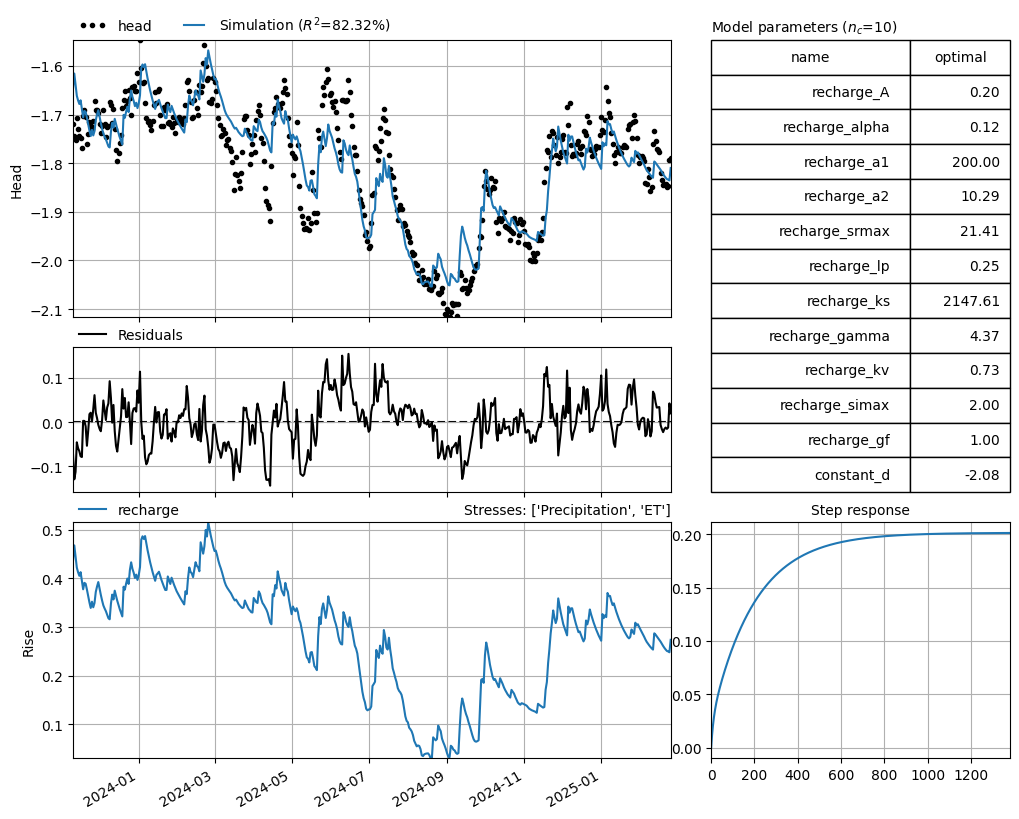

In [7]:
# --- Non-linear recharge with a XXXX response --------------------------------
ml = ps.Model(df_head_daily, name=name_model)   # keep default constant enabled

# Picking a recharge model with a non-linear recharge
rch = ps.rch.FlexModel(gw_uptake=True)  # non-linear recharge (can also try Berendrecht())

# Define the stressmodel with a Gamma response function
sm_1  = ps.RechargeModel(
    df_prec_daily,
    df_evap_daily,
    recharge=rch,
    rfunc=ps.DoubleExponential(),
    name="recharge"      # <- Gamma response function
)

# Adding the stressmodel to the model
ml.add_stressmodel(sm_1)

# #--- Constrain time scales & evap factor --------------------------------------
ml.set_parameter("recharge_a1", pmin=0,  pmax=200)   # days
ml.set_parameter("recharge_a2", pmin=10.0, pmax=200.0)  # days

# Adding thresholdt ransform
#ml.add_transform(ps.ThresholdTransform())

# Adding ARMA noise model
#noisemodel = ps.ArNoiseModel()
#ml.add_noisemodel(noisemodel)

# Solving the model
ml.solve(report=False)

# Plotting the model results
ml.plots.results(figsize=(10, 8))

In [8]:
ml.get_response_tmax("recharge", cutoff=0.95)

np.float64(599.1351270441004)

# Setting up the model including water contribution

The Time Series 'waterstand' has nan-values. Pastas will use the fill_nan settings to fill up the nan-values.


[<Axes: xlabel='DateTime', ylabel='Head'>,
 <Axes: >,
 <Axes: title={'right': "Stresses: ['Precipitation', 'ET']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}>,
 <Axes: title={'right': "Stresses: ['waterstand']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}>,
 <Axes: title={'left': 'Model parameters ($n_c$=13)'}>]

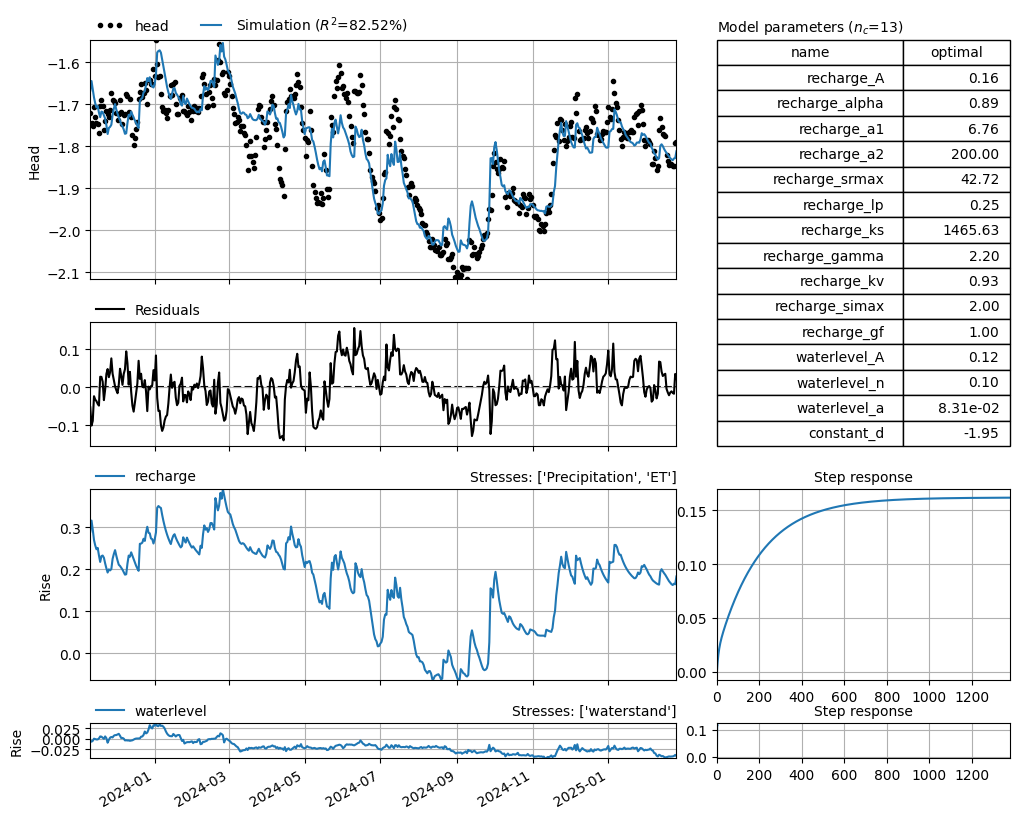

In [9]:
# --- Non-linear recharge with a XXXX response --------------------------------
ml_2 = ps.Model(df_head_daily, name=(name_model + "_buitenwaterstand"))   # keep default constant enabled

# WE DID NOT CHANGE THE RECHARGE MODEL HERE
# WE REUSE "sm_1" DEFINED ABOVE

# Adding buitenwaterstand as stressor
sm_2 = ps.StressModel(
    df_waterstand_daily,
    rfunc=ps.Gamma(),
    name="waterlevel",
    settings="waterlevel"
)

# Adding the stressmodel to the model
ml_2.add_stressmodel([sm_1, sm_2])

# --- Constrain time scales & evap factor --------------------------------------
#ml_2.set_parameter("recharge_a1", pmin=10,  pmax=100.0)   # days
#ml_2.set_parameter("recharge_a2", pmin=10.0, pmax=100.0)  # days

# Adding thresholdt ransform
ml.add_transform(ps.ThresholdTransform())

# Adding ARMA noise model
#noisemodel = ps.ArNoiseModel()
#ml.add_noisemodel(noisemodel)

# Solving the model
ml_2.solve(report=False)

# Plotting the model results
ml_2.plots.results(figsize=(10, 8))

In [10]:
ml_2.get_response_tmax("recharge", cutoff=0.95)

np.float64(599.1464547107979)

In [11]:
sim = ml_2.simulate()

['recharge', 'waterlevel']


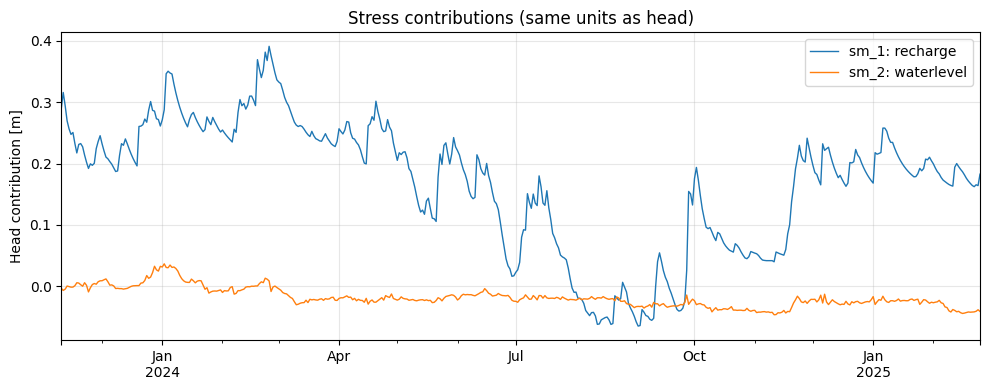

In [12]:
import matplotlib.pyplot as plt

# Inspect available stressmodel names (keys are the names you can pass to get_contribution)
print(list(ml_2.stressmodels.keys()))
# e.g. ['recharge', 'waterlevel']

# Grab contributions (meters) for each stress model
c_recharge   = ml_2.get_contribution('recharge')     # <- name of sm_1
c_waterlevel = ml_2.get_contribution('waterlevel')   # <- name of sm_2

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
c_recharge.plot(ax=ax, lw=1, label='sm_1: recharge')
c_waterlevel.plot(ax=ax, lw=1, label='sm_2: waterlevel')

ax.set_title('Stress contributions (same units as head)')
ax.set_ylabel('Head contribution [m]')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

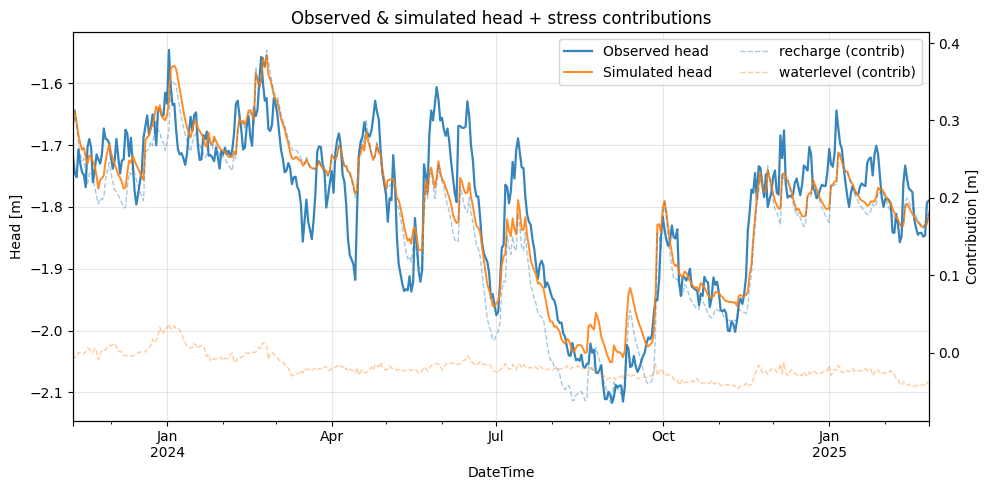

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
df_head_daily.plot(ax=ax, alpha=0.9, lw=1.6, label='Observed head')
sim.plot(ax=ax, lw=1.4, alpha=0.9, label='Simulated head')

ax2 = ax.twinx()
c_recharge.plot(ax=ax2, lw=1, linestyle='--', alpha=0.4, label='recharge (contrib)')
c_waterlevel.plot(ax=ax2, lw=1, linestyle='--', alpha=0.4, label='waterlevel (contrib)')

ax.set_title('Observed & simulated head + stress contributions')
ax.set_ylabel('Head [m]')
ax2.set_ylabel('Contribution [m]')
ax.grid(True, alpha=0.3)

# combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best', ncol=2)

plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- build series ---
sim = ml_2.simulate()
try:
    obs = df_head_daily
except AttributeError:
    obs = ml_2.observations.observations

c_recharge   = ml_2.get_contribution('recharge')
c_waterlevel = ml_2.get_contribution('waterlevel')

# align indexes
idx = obs.index.union(sim.index).union(c_recharge.index).union(c_waterlevel.index)
obs = obs.reindex(idx)
sim = sim.reindex(idx)
c_recharge   = c_recharge.reindex(idx).fillna(0.0)
c_waterlevel = c_waterlevel.reindex(idx).fillna(0.0)

# total contribution
c_total = (c_recharge + c_waterlevel).fillna(0.0)

# OPTIONAL: downsample to weekly to reduce bar clutter
# week = pd.to_datetime(idx).to_series().dt.to_period('W').dt.start_time
# obs, sim = obs.groupby(week).mean(), sim.groupby(week).mean()
# c_recharge, c_waterlevel, c_total = c_recharge.groupby(week).sum(), c_waterlevel.groupby(week).sum(), c_total.groupby(week).sum()

# --- figure with secondary y-axis ---
fig = make_subplots(specs=[[{"secondary_y": True}]])

# lines (primary y)
fig.add_trace(go.Scatter(x=obs.index, y=obs, name="Observed head", mode="lines"),
              secondary_y=False)
fig.add_trace(go.Scatter(x=sim.index, y=sim, name="Simulated head", mode="lines"),
              secondary_y=False)

# stacked component bars (secondary y) -> same offsetgroup so they stack
fig.add_trace(go.Bar(x=c_recharge.index, y=c_recharge, name="recharge (contrib)",
                     opacity=0.5, offsetgroup="components", hovertemplate="%{y:.3f} m"),
              secondary_y=True)

fig.add_trace(go.Bar(x=c_waterlevel.index, y=c_waterlevel, name="waterlevel (contrib)",
                     opacity=0.5, offsetgroup="components", hovertemplate="%{y:.3f} m"),
              secondary_y=True)

# total contribution bar (secondary y) -> different offsetgroup so it sits next to the stack
fig.add_trace(go.Bar(x=c_total.index, y=c_total, name="total contribution",
                     opacity=0.35, offsetgroup="total", marker_line_width=0.5,
                     hovertemplate="%{y:.3f} m"),
              secondary_y=True)

fig.update_layout(
    title="Observed & simulated head + stacked component bars and total bar",
    barmode="relative",      # stack within the same offsetgroup
    bargap=0.02,             # small gap between groups (stack vs total)
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
    margin=dict(l=40, r=20, t=60, b=40),
)

fig.update_yaxes(title_text="Head [m]", secondary_y=False)
fig.update_yaxes(title_text="Contribution [m]", secondary_y=True)

fig.show()